In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sympy import Max
from tqdm import tqdm
import os

from lkan.models import KANConv2d, KANLinearFFT

In [99]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 10),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class KAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            KANConv2d(
                in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0
            ),
            nn.MaxPool2d(2),
            KANConv2d(
                32,
                32,
                5,
                1,
            ),
            nn.MaxPool2d(2),
            nn.Flatten(),
            KANLinearFFT(32 * 4 * 4, 10),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


data_dir = "../../data/"
batch_size = 64
split_ratio = 0.8

lr = 0.0003
epochs = 5

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

dataset = torchvision.datasets.MNIST(data_dir, transform=transform, download=True)
ds_train, ds_val = torch.utils.data.random_split(
    dataset,
    [int(len(dataset) * split_ratio), len(dataset) - int(len(dataset) * split_ratio)],
)
loader_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False)
loader_train = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size, shuffle=True
)

cnn_model = MLP().to(device)
kan_model = KAN().to(device)


for model in [kan_model]:
    counter = 0
    for param in model.parameters():
        counter += param.numel()

    print(f"Number of parameters: {counter}")

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        train_acc = 0
        avg_train_loss = 0
        for x, y in tqdm(loader_train):
            x, y = x.to(device), y.to(device)

            opt.zero_grad()

            y_pred = model(x)
            loss = nn.CrossEntropyLoss()(y_pred, y)

            loss.backward()
            opt.step()

            train_acc += (y_pred.argmax(1) == y).float().mean().item()
            avg_train_loss += loss.item()

        avg_train_loss /= len(loader_train)
        train_acc /= len(loader_train)

        with torch.no_grad():
            acc = 0
            avg_loss = 0
            for x, y in loader_val:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = nn.CrossEntropyLoss()(y_pred, y)
                acc += (y_pred.argmax(1) == y).float().mean().item()
                avg_loss += loss.item()
            acc /= len(loader_val)
            avg_loss /= len(loader_val)
            print(
                f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss} - Val Loss: {avg_loss} - Train Acc: {train_acc} -Val Acc: {acc}"
            )

Number of parameters: 346784


100%|██████████| 750/750 [01:18<00:00,  9.58it/s]


Epoch 1/5 - Train Loss: 3.365563538458819 - Val Loss: 0.2960622436457151 - Train Acc: 0.8733333333333333 -Val Acc: 0.9476396276595744


100%|██████████| 750/750 [01:18<00:00,  9.54it/s]


Epoch 2/5 - Train Loss: 0.3139476678860762 - Val Loss: 0.42907967876662756 - Train Acc: 0.9505208333333334 -Val Acc: 0.9408244680851063


100%|██████████| 750/750 [01:18<00:00,  9.53it/s]


Epoch 3/5 - Train Loss: 0.3125513912533905 - Val Loss: 0.24820949375258505 - Train Acc: 0.9595208333333334 -Val Acc: 0.9673371010638298


100%|██████████| 750/750 [01:18<00:00,  9.54it/s]


Epoch 4/5 - Train Loss: 0.2516135666244633 - Val Loss: 0.32909248623741405 - Train Acc: 0.9689375 -Val Acc: 0.964095744680851


100%|██████████| 750/750 [01:18<00:00,  9.51it/s]


Epoch 5/5 - Train Loss: 0.27986303758934505 - Val Loss: 0.31017708553257733 - Train Acc: 0.9699583333333334 -Val Acc: 0.9700797872340425


In [100]:
from captum.attr import NeuronGradient
from receptive_fields.util.experiment_setup import open_experiment
from receptive_fields.util.modules import NamedFromSequential
import torch
from torchinfo import summary
from receptive_fields.util.activation_visualization import rescaleZeroOne
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [101]:
model.layers[:-2](x).shape

torch.Size([32, 32, 4, 4])

In [102]:
seq_model = NamedFromSequential(model.layers)

In [103]:
seq_model

NamedFromSequential(
  (KANConv2d_0): KANConv2d(
    (kernels): ModuleList(
      (0): KANLinearFFT(
        (base_fun): SiLU()
      )
    )
    (unfold): Unfold(kernel_size=5, dilation=1, padding=0, stride=1)
  )
  (MaxPool2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (KANConv2d_1): KANConv2d(
    (kernels): ModuleList(
      (0-31): 32 x KANLinearFFT(
        (base_fun): SiLU()
      )
    )
    (unfold): Unfold(kernel_size=5, dilation=1, padding=0, stride=1)
  )
  (MaxPool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Flatten_0): Flatten(start_dim=1, end_dim=-1)
  (KANLinearFFT_0): KANLinearFFT(
    (base_fun): SiLU()
  )
)

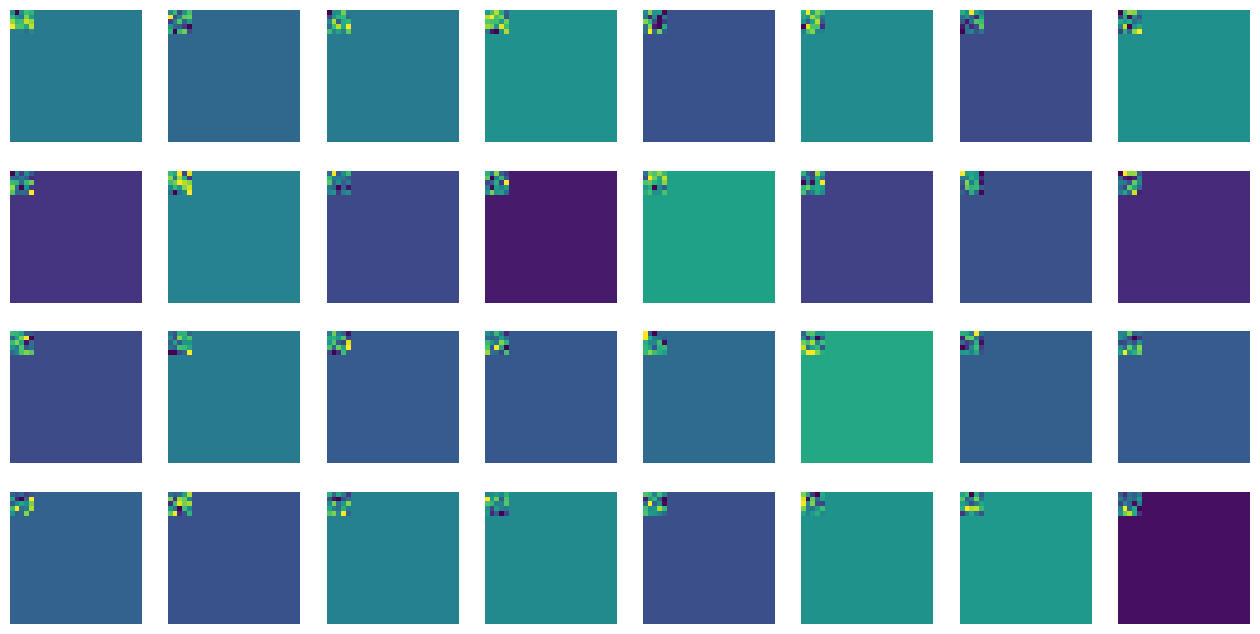

In [112]:
grad = NeuronGradient(seq_model, seq_model.KANConv2d_0)
fig, axes = plt.subplots(4,8, figsize=(16,8))
for i, ax in enumerate(axes.flat):
    rf = grad.attribute(torch.zeros(1,1,28,28, requires_grad=True).to(device), neuron_selector=(i,0,0))
    ax.imshow(rescaleZeroOne(rf[0].movedim(0,2).detach().cpu())[:96,:96])
    ax.axis('off')

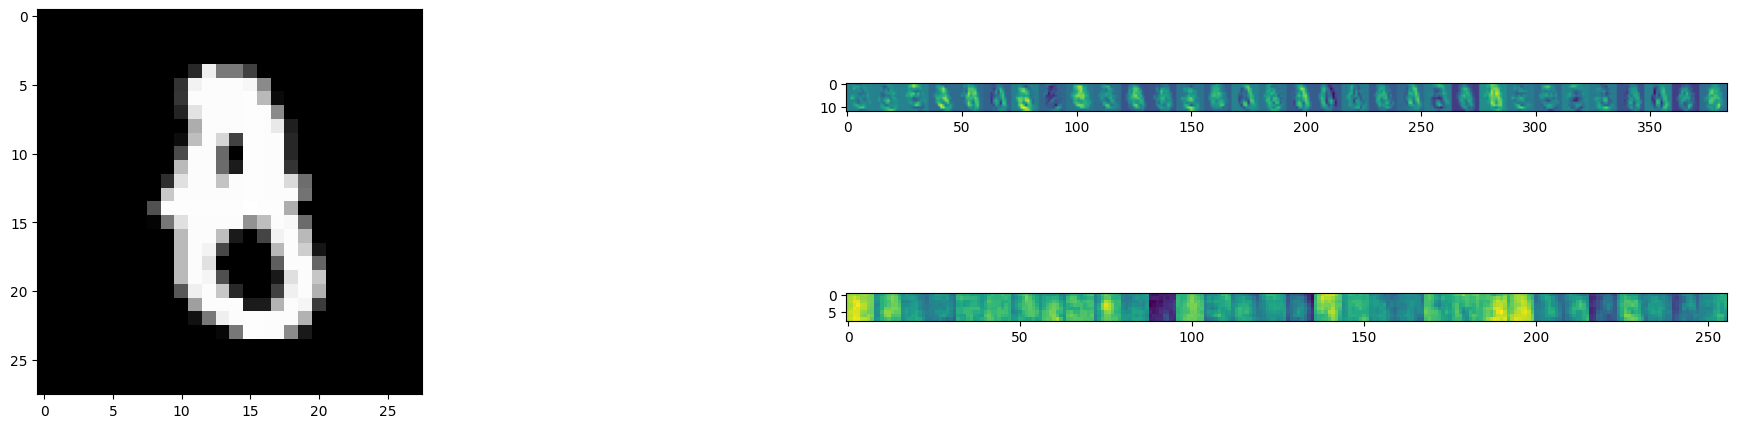

In [117]:
img_no = 2
plt.figure(figsize=(25,5))
plt.subplot(1, 2, 1)
plt.imshow(x[img_no,0].detach().cpu(), cmap="grey")
plt.subplot(2, 2, 2)
plt.imshow(rescaleZeroOne(model.layers[:2](x)[img_no].movedim(0,1).flatten(1,2).detach().cpu()))
plt.subplot(2, 2, 4)
plt.imshow(rescaleZeroOne(model.layers[:-3](x)[img_no].movedim(0,1).flatten(1,2).detach().cpu()))

In [106]:
model.layers[:-3](x)[img_no].flatten(0,1).shape

torch.Size([256, 8])